In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from PIL import Image
from tensorflow import keras
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics

In [2]:
def save_img(imgs,names):
  img_new = Image.new('L',(280,280))
  index = 0
  for i in range(0,280,80):
    for j in range(0,280,80):
      img = imgs[index]
      img = Image.fromarray(img,mode='L')
      img_new.paste(img,(i,j))
      index+=1
  img_new.save(names)

In [3]:
def feature_scale(x):
  x = tf.cast(x,dtype=tf.float32)/255.
#  y = tf.cast(y,dtype=tf.int32)
  return x

In [4]:
#Dim reduct nums
dim_reduce = 10
batch_num = 128
lr = 1e-3

In [5]:
(x,y),(x_test,y_test) = datasets.fashion_mnist.load_data()
data = tf.data.Dataset.from_tensor_slices(x)
data = data.map(feature_scale).shuffle(10000).batch(128)

data_test = tf.data.Dataset.from_tensor_slices(x_test)
data_test = data_test.map(feature_scale).batch(128)

data_iter = iter(data)
samples = next(data_iter)
print(samples[0].shape,samples[1].shape)

(28, 28) (28, 28)


In [6]:
class VAE(keras.Model):
  def __init__(self):
    super(VAE,self).__init__()
    #encoder
    self.fc_layer_1 = layers.Dense(128)
    self.fc_layer_2 = layers.Dense(dim_reduce)
    self.fc_layer_3 = layers.Dense(dim_reduce)
    
    
    self.fc_layer_4 = layers.Dense(128)
    self.fc_layer_5 = layers.Dense(784)
    

  def model_encoder(self, x):
    h = tf.nn.relu(self.fc_layer_1(x))
    mean_fc = self.fc_layer_2(h)
    var_fc = self.fc_layer_3(h)
    return mean_fc,var_fc

  def model_decoder(self, z):
    out = tf.nn.relu(self.fc_layer_4(z))
    out = self.fc_layer_5(out)
    return out

  def reparameter(self,mean_x,var_x):
    eps = tf.random.normal(var_x.shape)
    std = tf.exp(var_x)**0.5
    z = mean_x + std*eps
    return z
  
  def call(self, inputs, training=None):
    mean_x,var_x = self.model_encoder(inputs)
    z = self.reparameter(mean_x,var_x)
    x = self.model_decoder(z)
    return x,mean_x,var_x

In [7]:
model = VAE()
model.build(input_shape=(4,784))
optimizer = optimizers.Adam(lr=lr)
model.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  100480    
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
_________________________________________________________________
dense_2 (Dense)              multiple                  1290      
_________________________________________________________________
dense_3 (Dense)              multiple                  1408      
_________________________________________________________________
dense_4 (Dense)              multiple                  101136    
Total params: 205,604
Trainable params: 205,604
Non-trainable params: 0
_________________________________________________________________


c:\Users\TMU\anaconda3\envs\tf2.6\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


0 0 loss: 238.72024536132812 kl_div: 14.280855178833008
0 100 loss: 237.54055786132812 kl_div: 15.24148178100586
0 200 loss: 241.55545043945312 kl_div: 15.16860580444336
0 300 loss: 249.7498321533203 kl_div: 15.067943572998047
0 400 loss: 246.13612365722656 kl_div: 14.999892234802246
1 0 loss: 251.3238525390625 kl_div: 14.654507637023926
1 100 loss: 248.554443359375 kl_div: 15.024106979370117
1 200 loss: 266.115966796875 kl_div: 15.020110130310059
1 300 loss: 247.8163604736328 kl_div: 14.665776252746582
1 400 loss: 254.7447967529297 kl_div: 15.206475257873535
2 0 loss: 232.80821228027344 kl_div: 15.051816940307617
2 100 loss: 246.8177947998047 kl_div: 15.692456245422363
2 200 loss: 250.3421173095703 kl_div: 15.10068130493164
2 300 loss: 244.91529846191406 kl_div: 14.84742546081543
2 400 loss: 241.63128662109375 kl_div: 14.583186149597168
3 0 loss: 240.9456787109375 kl_div: 15.00925064086914
3 100 loss: 243.10118103027344 kl_div: 14.402985572814941
3 200 loss: 238.9879150390625 kl_div: 

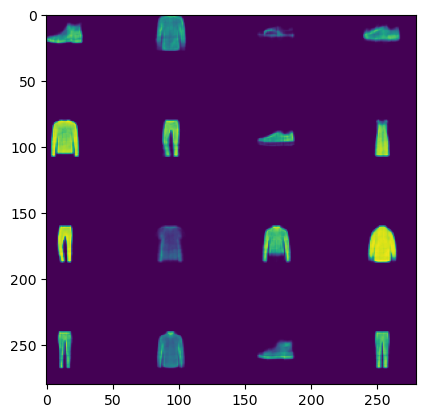

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(10):
  for step,x in enumerate(data):
    x = tf.reshape(x,[-1,784])
    with tf.GradientTape() as tape:
      logits,mean_x,var_x = model(x)
      loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=logits)
      loss = tf.reduce_sum(loss)/x.shape[0]
      kl_div = -0.5*(var_x+1-mean_x**2-tf.exp(var_x))
      kl_div = tf.reduce_sum(kl_div)/x.shape[0]
      
      loss = loss + 1.*kl_div
    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    if step %100==0:
      print(i,step,'loss:',float(loss),'kl_div:',float(kl_div))
      
  x = next(iter(data_test))
  val_x = tf.reshape(x,[-1,784])
  logits,_,_ = model(val_x)
  x_hat = tf.sigmoid(logits)
  x_hat = tf.reshape(x_hat,[-1,28,28])
  x_hat = x_hat.numpy()*255
  x_hat = x_hat.astype(np.uint8)
  if i==9:
    save_img(x_hat,'./img_results/VAE_img_%d.png'%i)
    img = mpimg.imread('./img_results/VAE_img_%d.png'%i)
    imgplot = plt.imshow(img)
    plt.show()

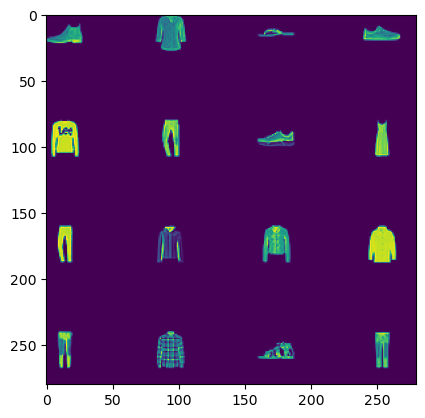

In [13]:
img = mpimg.imread('./img_results/AE_img_total.png')
imgplot = plt.imshow(img)
plt.show()